In [1]:
import math
import pandas as pd
from langdetect import detect
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import CountVectorizer
import math
import matplotlib.pyplot as plt

In [2]:
lem = WordNetLemmatizer() #create lemmatizer

In [3]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kseniapavlina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
dictionary = pd.read_csv('../data/processedDict.csv')
dictionary['word'].apply(lambda x: lem.lemmatize(x, pos='n'))

,ndf
count,352.000000
mean,0.006195
std,0.002955
min,0.000036
25%,0.003706
50%,0.006419
75%,0.009169
max,0.009999


In [5]:
filepath = '../data/en_reviews/Manchester.csv'
reviews = pd.read_csv(filepath)

# reviews = reviews['date']
reviews

table = str.maketrans('', '', string.punctuation) #mapping to strip punctuation in review

#strip punct of each review -> lemmatise -> output is list of words so join into sentences
reviews['comments'] = reviews.comments.apply(lambda review: ' '.join(map(str, [lem.lemmatize(word.translate(table), pos='n') for word in review.lower().split()])))
reviews

reviews['date'] = pd.to_datetime(reviews['date'])

In [6]:
#### DELETE THIS LATER ###
mask = (reviews['date'] >= '2015-01-01') & (reviews['date'] < '2017-01-01')
# mask = (reviews['date'] >= '2014-01-01') & (reviews['date'] < '2017-01-01')
reviews = reviews.loc[mask].copy()
reviews

reviews.describe()

,Unnamed: 0,listing_id,id,reviewer_id
count,13114.000000,1.311400e+04,1.311400e+04,1.311400e+04
mean,22663.608586,7.414709e+06,8.003472e+07,4.193421e+07
std,14192.299032,4.511850e+06,2.845773e+07,2.778989e+07
min,27.000000,6.895100e+04,2.466198e+07,2.477000e+03
25%,11392.250000,3.896003e+06,5.582803e+07,2.008795e+07
50%,20928.500000,6.898641e+06,8.073873e+07,3.757358e+07
75%,33627.750000,1.132370e+07,1.067308e+08,6.065311e+07
max,93324.000000,2.299882e+07,1.240321e+08,1.086679e+08


In [14]:
dictionary.columns

Index(['word', 'cat_lev1', 'cat_lev2', 'cat_lev3', 'ndf'], dtype='object')

In [78]:
def get_trends_nice(category, subcats):
    years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
    allwords = reviews['comments'].tolist()
    allwords = " ".join(allwords)
    unique_words = set(allwords.split(' '))
    len(unique_words)

    unique_words = list(unique_words)
    unique_words = [string for string in unique_words if string != ""]
    len(unique_words)

    unique_words[2]

    ls = []
    for word in unique_words:
        word = ''.join([i for i in word if not i.isdigit()])
        ls += [word]
    # result = ''.join([i for i in s if not i.isdigit()])
    unique_words= ls
    unique_words = [string for string in unique_words if string != ""]
    len(unique_words)

    def countWords(word, review):
        count = 0
        for i in review:
            if i == word:
                count+=1
        return count

    def getDenom(review, unique_words):
        count = 0
        den = 0
        ls = []
        review = review.split()
        for word in review:
            kmp = countWords(word, review)
            if (kmp > 0 and word not in ls):
                ls += [word]
                den += math.log(1 + kmp)
        return den

    reviews['den'] = reviews['comments'].apply(lambda x: getDenom(x, unique_words))

    def getNom(category, review, dictionary, cat_levl="cat_lev1"):
        nom = 0
        review = review.split()
        dictionaryWords = dictionary[(dictionary[cat_levl] == category)]
        dictionaryWords = dictionaryWords['word']
        for word in dictionaryWords:
            nom += math.log(1 + review.count(word))
        return nom

    reviews['temp'] = reviews['comments'].apply(lambda x: getNom(category, x, dictionary))
    reviews[category] = reviews['temp']*100/reviews['den']

    k = {}
    for subcat in subcats:
        temp = reviews['comments'].apply(lambda x: getNom(subcat, x, dictionary, cat_levl="cat_lev3"))
        reviews[subcat] = temp * 100 / reviews["den"]
        k[subcat] = reviews[subcat].loc[reviews[subcat] > 0].min()
        
    print(k)
    
    k_business= reviews[category].loc[reviews[category] > 0]
    k_business = k_business.min()
    print(k_business)

    def adoptionForSetOfReviews(category, setOfReviews, dictionary, startDate, endDate, k):
        adoption = 1
        mask = (setOfReviews['date'] >= startDate) & (setOfReviews['date'] < endDate)
        setOfReviews = setOfReviews.loc[mask]
        setOfReviews = setOfReviews[category]
        if (len(setOfReviews) == 0):
            return 0
        else:
            b = 1/len(setOfReviews)
            for review in setOfReviews:
                adoption *= math.pow((review + k),b)
            adoption = adoption - k
            return adoption

    d2 = {'Year' : years, 'value':0.0}
    out = pd.DataFrame(data=d2)
    
    for i in range(len(years)):
#         out.at[i, "value_{}".format(category)] = adoptionForSetOfReviews(category, reviews, dictionary, "{}-01-01".format(years[i]), "{}-01-01".format(years[i] + 1), k_business)
        for subcat in subcats:
            out.at[i, "value_{}_{}".format(category, subcat)] = adoptionForSetOfReviews(subcat, reviews, dictionary, "{}-01-01".format(years[i]), "{}-01-01".format(years[i] + 1), k[subcat])
            

    plt.bar(out.Year, out.value)
    return out

{'meal': 0.381616197371929, 'people': 0.4560553119418164, 'personality_host': 0.31467927930623746, 'talking': 0.31059423255865254, 'sharing': 0.31059423255865254}
0.5071388629678919


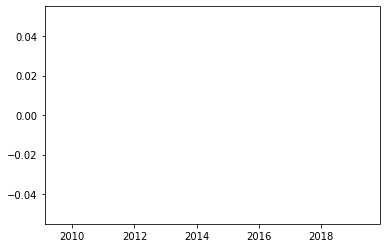

In [82]:
subcats = ["meal", "people", "personality_host", "talking", "sharing"]
soci = get_trends_nice("social", subcats)

In [83]:
soci

,Year,value,value_social_meal,value_social_people,value_social_personality_host,value_social_talking,value_social_sharing
0,2010,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,2011,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,2012,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,2013,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,2014,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
5,2015,0.0,0.126902,0.783337,0.380509,0.041375,0.081916
6,2016,0.0,0.092350,0.587199,0.306337,0.032276,0.057707
7,2017,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
8,2018,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
9,2019,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [84]:
a = pd.DataFrame(columns=["year", "subcat", "val"])

for subcat in subcats:
    ap = {"year": soci["Year"], "val": soci["value_social_{}".format(subcat)]}
    ap = pd.DataFrame(data=ap)
    ap["subcat"] = subcat
    print(ap)
    a = a.append(ap)
a

   year       val subcat
0  2010  0.000000   meal
1  2011  0.000000   meal
2  2012  0.000000   meal
3  2013  0.000000   meal
4  2014  0.000000   meal
5  2015  0.126902   meal
6  2016  0.092350   meal
7  2017  0.000000   meal
8  2018  0.000000   meal
9  2019  0.000000   meal
   year       val  subcat
0  2010  0.000000  people
1  2011  0.000000  people
2  2012  0.000000  people
3  2013  0.000000  people
4  2014  0.000000  people
5  2015  0.783337  people
6  2016  0.587199  people
7  2017  0.000000  people
8  2018  0.000000  people
9  2019  0.000000  people
   year       val            subcat
0  2010  0.000000  personality_host
1  2011  0.000000  personality_host
2  2012  0.000000  personality_host
3  2013  0.000000  personality_host
4  2014  0.000000  personality_host
5  2015  0.380509  personality_host
6  2016  0.306337  personality_host
7  2017  0.000000  personality_host
8  2018  0.000000  personality_host
9  2019  0.000000  personality_host
   year       val   subcat
0  2010  0.00000

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,subcat,val,year
0,meal,0.000000,2010
1,meal,0.000000,2011
2,meal,0.000000,2012
3,meal,0.000000,2013
4,meal,0.000000,2014
5,meal,0.126902,2015
6,meal,0.092350,2016
7,meal,0.000000,2017
8,meal,0.000000,2018
9,meal,0.000000,2019


In [85]:
pivot_social = a.pivot(index='year', columns='subcat', values='val')
pivot_social

subcat,meal,people,personality_host,sharing,talking
year,,,,,
2010,0.000000,0.000000,0.000000,0.000000,0.000000
2011,0.000000,0.000000,0.000000,0.000000,0.000000
2012,0.000000,0.000000,0.000000,0.000000,0.000000
2013,0.000000,0.000000,0.000000,0.000000,0.000000
2014,0.000000,0.000000,0.000000,0.000000,0.000000
2015,0.126902,0.783337,0.380509,0.081916,0.041375
2016,0.092350,0.587199,0.306337,0.057707,0.032276
2017,0.000000,0.000000,0.000000,0.000000,0.000000
2018,0.000000,0.000000,0.000000,0.000000,0.000000


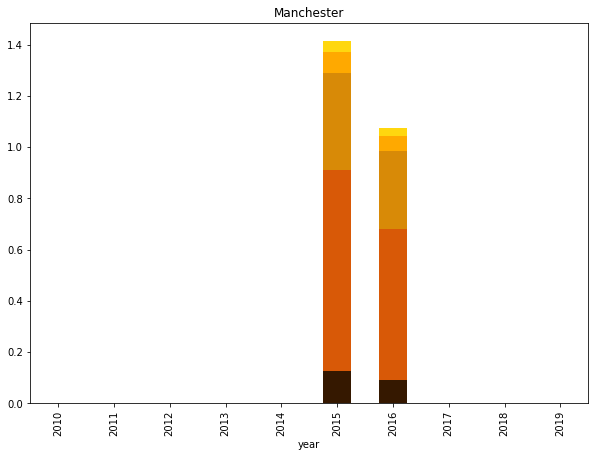

In [86]:
ax = pivot_social.loc[:,['meal','people', 'personality_host', 'sharing', 'talking']].plot.bar(stacked=True, figsize=(10,7), color=['#351800','#D85907','#D88A07','#FFA900','#FFD70F'])
plt.title("Manchester")
ax.get_legend().remove()

In [46]:
soci[["Year", "value_social_meal"]]

,Year,value_social_meal
0,2010,0.000000
1,2011,0.000000
2,2012,0.000000
3,2013,0.000000
4,2014,0.000000
5,2015,2.010455
6,2016,1.466422
7,2017,0.000000
8,2018,0.000000
9,2019,0.000000


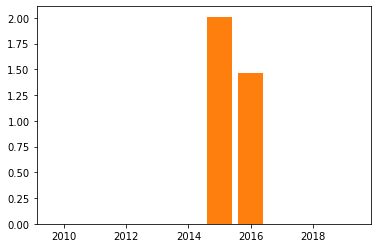

In [47]:
p = {}
# "value_{}_{}".format(category, subcat)
for i in range(len(subcats)):
    p[subcats[i]] = plt.bar(soci["Year"], soci["value_{}_{}".format("social", subcats[i])])
plt.show()

In [42]:
soci

,Year,value,value_social,value_social_meal,value_social_people,value_social_personality_host,value_social_talking,value_social_sharing
0,2010,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2011,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2012,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2013,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2014,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,2015,0.0,2.010455,2.010455,2.010455,2.010455,2.010455,2.010455
6,2016,0.0,1.466422,1.466422,1.466422,1.466422,1.466422,1.466422
7,2017,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,2018,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,2019,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [39]:
def get_trends_sad(category, subcats):
    years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
    allwords = reviews['comments'].tolist()
    allwords = " ".join(allwords)
    unique_words = set(allwords.split(' '))
    len(unique_words)

    unique_words = list(unique_words)
    unique_words = [string for string in unique_words if string != ""]
    len(unique_words)

    unique_words[2]

    ls = []
    for word in unique_words:
        word = ''.join([i for i in word if not i.isdigit()])
        ls += [word]
    # result = ''.join([i for i in s if not i.isdigit()])
    unique_words= ls
    unique_words = [string for string in unique_words if string != ""]
    len(unique_words)

    def countWords(word, review):
        count = 0
        for i in review:
            if i == word:
                count+=1
        return count

    def getDenom(review, unique_words):
        count = 0
        den = 0
        ls = []
        review = review.split()
        for word in review:
            kmp = countWords(word, review)
            if (kmp > 0 and word not in ls):
                ls += [word]
                den += math.log(1 + kmp)
        return den

    reviews['den'] = reviews['comments'].apply(lambda x: getDenom(x, unique_words))

    def getNom(category, review, dictionary, cat_levl="cat_lev1"):
        nom = 0
        review = review.split()
        dictionaryWords = dictionary[(dictionary[cat_levl] == category)]
        dictionaryWords = dictionaryWords['word']
        for word in dictionaryWords:
            nom += math.log(1 + review.count(word))
        return nom

    reviews['temp'] = reviews['comments'].apply(lambda x: getNom(category, x, dictionary))
    reviews[category] = reviews['temp']*100/reviews['den']

    k = {}
    for subcat in subcats:
        temp = reviews['comments'].apply(lambda x: getNom(subcat, x, dictionary, cat_levl="cat_lev3"))
        reviews[subcat] = temp * 100 / reviews["den"]
        k[subcat] = reviews[subcat].loc[reviews[subcat] > 0].min()
        
    print(k)
    
    k_business= reviews[category].loc[reviews[category] > 0]
    k_business = k_business.min()
    print(k_business)

    def adoptionForSetOfReviews(category, setOfReviews, dictionary, startDate, endDate, k):
        adoption = 1
        mask = (setOfReviews['date'] >= startDate) & (setOfReviews['date'] < endDate)
        setOfReviews = setOfReviews.loc[mask]
        setOfReviews = setOfReviews[category]
        if (len(setOfReviews) == 0):
            return 0
        else:
            b = 1/len(setOfReviews)
            for review in setOfReviews:
                adoption *= math.pow((review + k),b)
            adoption = adoption - k
            return adoption

#     d2 = {'Year' : years, 'value':0.0}
#     out = pd.DataFrame(data=d2)
    out = pd.DataFrame()
    
    for j, subcat in enumerate(subcats):
        for i in range(len(years)):
            out.at[i+j*len(subcats), "Year"] = "{}-01-01".format(years[i])
            out.at[i+j*len(subcats), "subcat"] = adoptionForSetOfReviews(category, reviews, dictionary, "{}-01-01".format(years[i]), "{}-01-01".format(years[i] + 1), k_business)
            

#     plt.bar(out.Year, out.value)
    return out

In [40]:
subcats = ["meal", "people"]#"personality_host", "talking", "sharing"]
social = get_trends_sad("social", subcats)

{'meal': 0.381616197371929, 'people': 0.4560553119418164}
0.5071388629678919


In [41]:
social

,Year,subcat
0,2010-01-01,0.000000
1,2011-01-01,0.000000
2,2010-01-01,0.000000
3,2011-01-01,0.000000
4,2012-01-01,0.000000
5,2013-01-01,0.000000
6,2014-01-01,0.000000
7,2015-01-01,2.010455
8,2016-01-01,1.466422
9,2017-01-01,0.000000


In [34]:
social

,Year,value,meal,people,personality_host,talking,sharing
0,2010.0,0.0,0.000000,NaN,NaN,NaN,NaN
1,2011.0,0.0,0.000000,NaN,NaN,NaN,NaN
2,2012.0,0.0,0.000000,NaN,NaN,NaN,NaN
3,2013.0,0.0,0.000000,NaN,NaN,NaN,NaN
4,2014.0,0.0,0.000000,NaN,NaN,NaN,NaN
5,2015.0,0.0,2.010455,0.000000,NaN,NaN,NaN
6,2016.0,0.0,1.466422,0.000000,NaN,NaN,NaN
7,2017.0,0.0,0.000000,0.000000,NaN,NaN,NaN
8,2018.0,0.0,0.000000,0.000000,NaN,NaN,NaN
9,2019.0,0.0,0.000000,0.000000,NaN,NaN,NaN


{'advice': nan, 'personality_host2': nan, 'logistic': nan, 'location': nan, 'property_type': nan, 'facilities': nan, 'interiors': nan, 'communication': nan}
1.5834402251970534


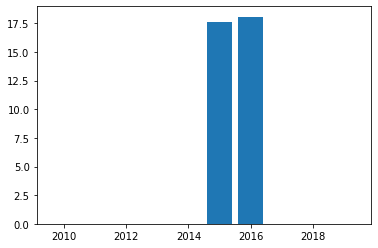

In [13]:
subcats = ["advice", "personality_host2", "logistic", "location", 
           "property_type", "facilities", "interiors", "communication"]
busi = get_trends_sad("business", subcats)